In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score, precision_score,recall_score, mean_squared_error, roc_auc_score
from sklearn.metrics import  confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
import statsmodels.api as sm
from itertools import combinations
from scipy.stats import pearsonr, chi2_contingency
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
import sklearn.metrics as metrics
import matplotlib.patches as  mpatches
import timeit


In [27]:
import xgboost
xgboost.__version__

'1.6.2'

In [28]:
df = pd.read_csv("../input/lendingclub/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv", parse_dates=['issue_d'], infer_datetime_format=True)
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(df.head())
df = df[(df.issue_d >= '2018-01-01 00:00:00') ]
df = df.sample(n=200000)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,2015-12-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,2015-12-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,N

# Prediction model for Grade

In [29]:
numerical_features = [
    'acc_now_delinq', 'acc_open_past_24mths', 'all_util', 'annual_inc',
       'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'collection_recovery_fee',
       'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'dti',
       'dti_joint', 'fico_range_high', 'fico_range_low', 'funded_amnt',
       'funded_amnt_inv', 'hardship_amount', 'hardship_dpd',
       'hardship_last_payment_amount', 'hardship_payoff_balance_amount',
       'il_util', 'inq_fi', 'inq_last_12m', 'inq_last_6mths',
       'installment','last_fico_range_high',
       'last_fico_range_low', 'last_pymnt_amnt', 'loan_amnt',
       'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_last_delinq', 'mths_since_last_major_derog',
       'mths_since_last_record', 'mths_since_rcnt_il',
       'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_30dpd',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc',
       'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
       'open_rv_12m', 'open_rv_24m',
       'orig_projected_additional_accrued_interest', 'out_prncp',
       'out_prncp_inv', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec',
       'pub_rec_bankruptcies', 'recoveries', 'revol_bal',
       'revol_bal_joint', 'revol_util',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med', 'sec_app_fico_range_high',
       'sec_app_fico_range_low', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_mths_since_last_major_derog',
       'sec_app_num_rev_accts', 'sec_app_open_acc', 'sec_app_open_act_il',
       'sec_app_revol_util', 'settlement_amount', 'settlement_percentage',
       'settlement_term', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal',
       'tot_hi_cred_lim', 'total_acc', 'total_bal_ex_mort',
       'total_bal_il', 'total_bc_limit', 'total_cu_tl',
       'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp',
       'total_rev_hi_lim'
]
categorical_features = [
       'term', 'emp_length',
       'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan',
       'purpose', 'title',
       'initial_list_status', 'last_pymnt_d',
       'verification_status_joint',
       'hardship_flag', 'hardship_reason',
       'hardship_status', 'hardship_start_date', 'hardship_end_date',
       'payment_plan_start_date', 'hardship_loan_status',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date'
]
label_column = 'grade'

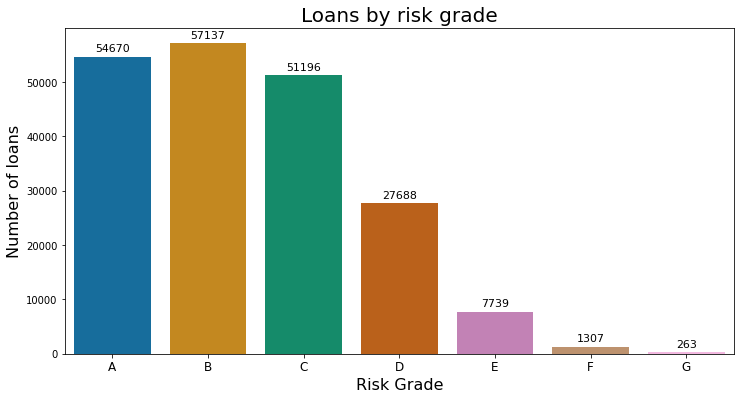

In [30]:
fig = plt.figure(figsize = (12,6))
ax = sns.countplot(x ='grade',data=df, order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'], palette='colorblind')
for bar in ax.patches:
    ax.annotate(format(bar.get_height()),
        (bar.get_x() + bar.get_width() / 2,
        bar.get_height()), ha='center', va='center',
        size=11, xytext=(0, 8),
        textcoords='offset points')
plt.xticks(fontsize=12)
ax.set_xlabel("Risk Grade", fontsize = 16)
ax.set_ylabel("Number of loans", fontsize = 16)
ax.set_title("Loans by risk grade", fontsize = 20)
plt.show()

In [31]:
df.grade = df.grade.replace({'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6} )
df = df.dropna(subset = ['grade'])

In [32]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=1, stratify=df.grade)

# Base Line

In [33]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_data[numerical_features + categorical_features], train_data[label_column])
dummy_pred = dummy_clf.predict(test_data[numerical_features + categorical_features])

In [34]:
y_test = test_data[label_column].to_numpy()

In [35]:
def print_results( y_pred, y_test, y_pred_prob):
    print('Test accuracy score: ' + str(accuracy_score( y_test,y_pred)))
    print('Test precision score: ' + str(precision_score(  y_test, y_pred, average='micro')))
    print('Test ROC AUC score: ' + str(roc_auc_score(y_test, y_pred_prob, average="weighted", multi_class="ovr")))

In [36]:
y_pred_prob = dummy_clf.predict_proba(test_data[numerical_features + categorical_features])
print_results(dummy_pred, y_test, y_pred_prob)

Test accuracy score: 0.285675
Test precision score: 0.285675
Test ROC AUC score: 0.5


# Grade prediction model

In [37]:
categorical_transformer = Pipeline(
    steps=[
        ("categorical_imputer", SimpleImputer(strategy="constant")),
        (
            "categorical_encoder",
            OneHotEncoder(handle_unknown='ignore'),
        ),
    ]
)

numerical_transformer = Pipeline(
    steps=[
        ("numerical_imputer", SimpleImputer(strategy="constant", fill_value = -999999)),
        (
            "numerical_scaler",
            StandardScaler(),
        ),
    ]
)

preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            categorical_transformer,
            categorical_features,
        ),
        (
            "numerical",
            numerical_transformer,
            numerical_features,
        ),
    ]
)

In [38]:
model = XGBClassifier()

In [39]:
pipe = Pipeline([("preprocessor", preprocessor),
                        ("model", model)])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['term', 'emp_length',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'loan_status', 'pymnt_plan',
                                                   'purpose', 'title',
                                                   'initial_list_status',
                                                   'las...
        

In [40]:
%%time
pipe.fit(
    train_data[numerical_features + categorical_features], train_data[label_column]
)

CPU times: user 43min 6s, sys: 3.41 s, total: 43min 9s
Wall time: 11min 6s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['term', 'emp_length',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'loan_status', 'pymnt_plan',
                                                   'purpose', 'title',
                                                   'initial_list_status',
                                                   'las...
        

In [41]:
y_test = test_data[label_column].to_numpy()
y_pred = pipe.predict(test_data[numerical_features + categorical_features])
y_pred_prob = pipe.predict_proba(test_data[numerical_features + categorical_features])
print_results(y_pred, y_test, y_pred_prob)

Test accuracy score: 0.96255
Test precision score: 0.96255
Test ROC AUC score: 0.9979819021928034


Feature importance

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


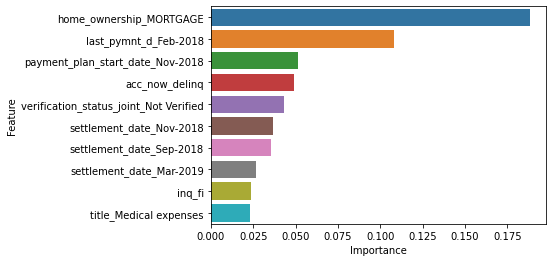

In [42]:
names_num = train_data[numerical_features].columns.values
names_cat = pipe.named_steps['preprocessor'].named_transformers_['categorical'].named_steps["categorical_encoder"].get_feature_names(categorical_features)
names = np.concatenate([names_num, names_cat])
imp = pipe.steps[1][1].feature_importances_
data = pd.DataFrame({'Feature': names, 'Importance': imp})
data = data.sort_values('Importance', ascending=False)[:10]
sns.barplot(x='Importance', y='Feature', data=data);

Confusion matrix

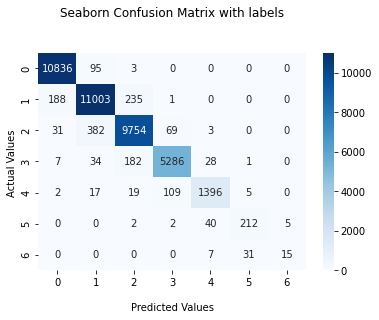

In [43]:
y_test = test_data[label_column].to_numpy()
y_pred = pipe.predict(test_data[numerical_features + categorical_features])

confm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confm, annot=True, cmap='Blues',fmt='d')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels([0 ,1, 2, 3, 4, 5, 6])
ax.yaxis.set_ticklabels([0 ,1, 2, 3, 4, 5, 6])

plt.show()

# Making smaller model

In [44]:
numerical_features = [
    'acc_now_delinq'
]
categorical_features = [
    'verification_status',
    'title',
    'hardship_loan_status',
    'hardship_status',
    'debt_settlement_flag',
    'payment_plan_start_date',
    'last_pymnt_d'
]
label_column = 'grade'

In [45]:
preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            categorical_transformer,
            categorical_features,
        ),
        (
            "numerical",
            numerical_transformer,
            numerical_features,
        ),
    ]
)

In [46]:
pipe = Pipeline([("preprocessor", preprocessor),
                        ("model", model)])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['verification_status',
                                                   'title',
                                                   'hardship_loan_status',
                                                   'hardship_status',
                                                   'debt_settlement_flag',
                                                   'payment_plan_start_date',
                                                   'last_pymn...
           

In [47]:
%%time
pipe.fit(
    train_data[numerical_features + categorical_features], train_data[label_column]
)

CPU times: user 1min 55s, sys: 212 ms, total: 1min 55s
Wall time: 29.9 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['verification_status',
                                                   'title',
                                                   'hardship_loan_status',
                                                   'hardship_status',
                                                   'debt_settlement_flag',
                                                   'payment_plan_start_date',
                                                   'last_pymn...
           

In [48]:
y_test = test_data[label_column].to_numpy()
y_pred = pipe.predict(test_data[numerical_features + categorical_features])
y_pred_prob = pipe.predict_proba(test_data[numerical_features + categorical_features])
print_results(y_pred, y_test, y_pred_prob)

Test accuracy score: 0.328475
Test precision score: 0.328475
Test ROC AUC score: 0.5859759922308089


In [49]:
import joblib

filename = 'gradeModel.joblib'
joblib.dump(pipe, filename)



['gradeModel.joblib']

In [50]:
test_data[numerical_features + categorical_features].head(10)

,acc_now_delinq,verification_status,title,hardship_loan_status,hardship_status,debt_settlement_flag,payment_plan_start_date,last_pymnt_d
478307,0.0,Source Verified,Other,NaN,NaN,N,NaN,Mar-2018
750768,0.0,Source Verified,Debt consolidation,NaN,NaN,N,NaN,Mar-2019
431922,0.0,Not Verified,Other,NaN,NaN,N,NaN,Mar-2019
503254,0.0,Not Verified,Debt consolidation,NaN,NaN,N,NaN,Mar-2019
1490421,0.0,Source Verified,Debt consolidation,NaN,NaN,N,NaN,Mar-2019
1589978,0.0,Verified,Debt consolidation,NaN,NaN,N,NaN,Mar-2019
1585108,0.0,Source Verified,Credit card refinancing,NaN,NaN,N,NaN,Mar-2019
450204,0.0,Source Verified,Debt consolidation,NaN,NaN,N,NaN,Mar-2019
1577501,0.0,Source Verified,Debt consolidation,NaN,NaN,N,NaN,Mar-2019
758362,0.0,Not Verified,Debt consolidation,NaN,NaN,N,NaN,Mar-2019


In [51]:
import pickle

pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(pipe, file)